## 🧠 Garbage Classification using Transfer Learning
### Model: EfficientNetV2B2 and ResNet50

In [42]:
import numpy as np  
import matplotlib.pyplot as plt  
import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras import Layer  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras import layers, optimizers, callbacks  
from sklearn.utils.class_weight import compute_class_weight  
from tensorflow.keras.applications import EfficientNetV2B2, ResNet50
from sklearn.metrics import confusion_matrix, classification_report 
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns


## Dataset Analysis

In [2]:
dataset_path = r"C:\Users\Kaustubh Pareek\Downloads\archive\TrashType_Image_Dataset"

# Retrieve the names of all folders in the dataset
garbage_types = os.listdir(dataset_path)
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # For displaying the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

cardboard folder contains 403 images.
glass folder contains 501 images.
metal folder contains 410 images.
paper folder contains 594 images.
plastic folder contains 482 images.
trash folder contains 137 images.


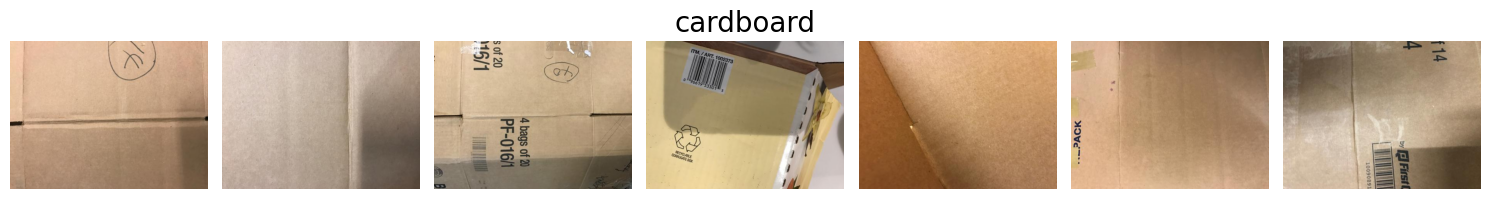

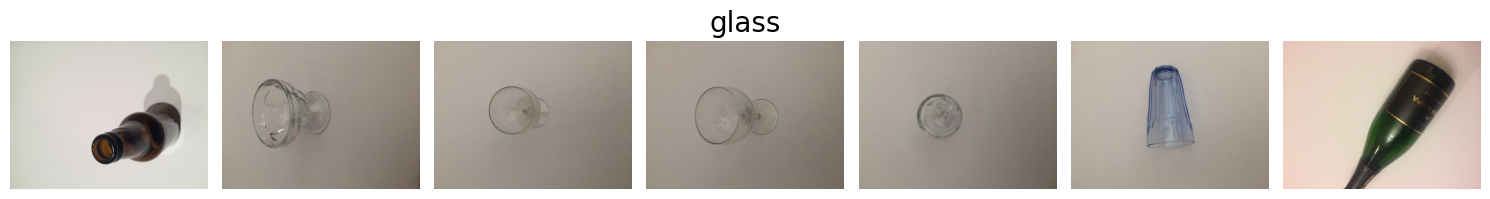

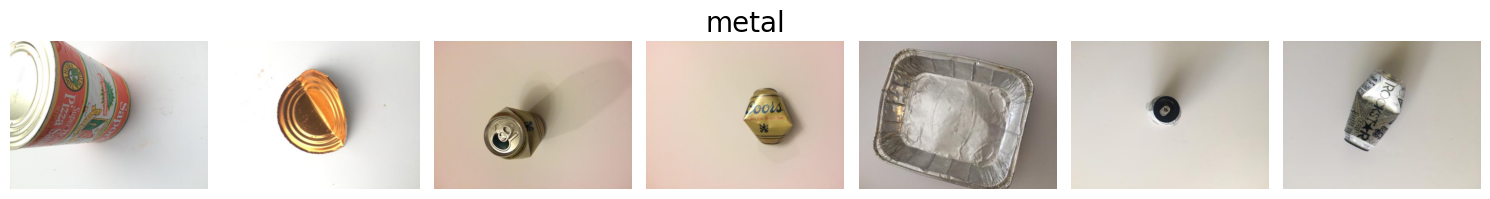

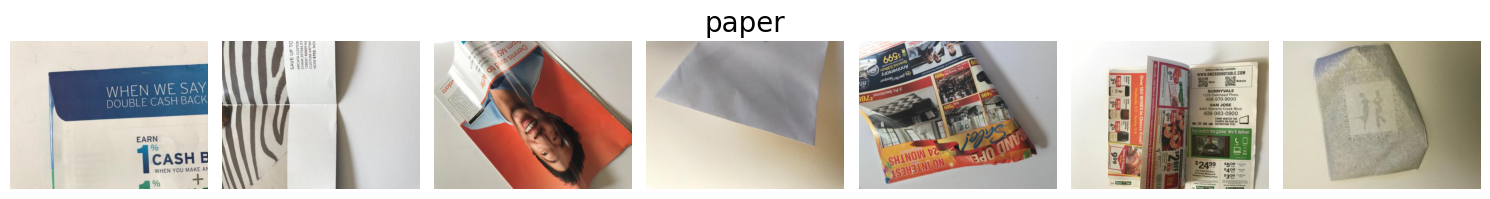

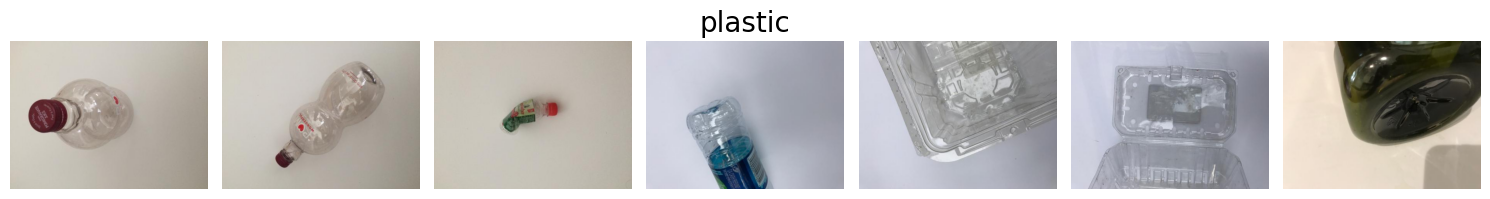

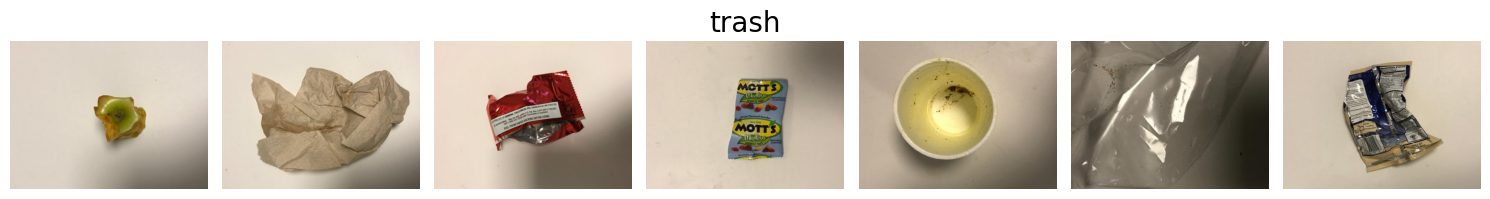

In [26]:
# iteratating over each trash type to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        image_files = image_files[:7]
    fig, axs = plt.subplots(1, 7, figsize=(15, 2))
    for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        
    plt.tight_layout()
    fig.suptitle(garbage_type, fontsize=20, y=1.03)
    plt.show()

## Data Preparation

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle = True,
    image_size=(124,124),
    batch_size=32
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle = True,
    image_size=(124, 124),
    batch_size=32
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [24]:
# get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# split the validation dataset into two equal parts:
# first half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2) 
# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)   

In [25]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


In [27]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [ ]:
class_names = train_ds.class_names

# get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


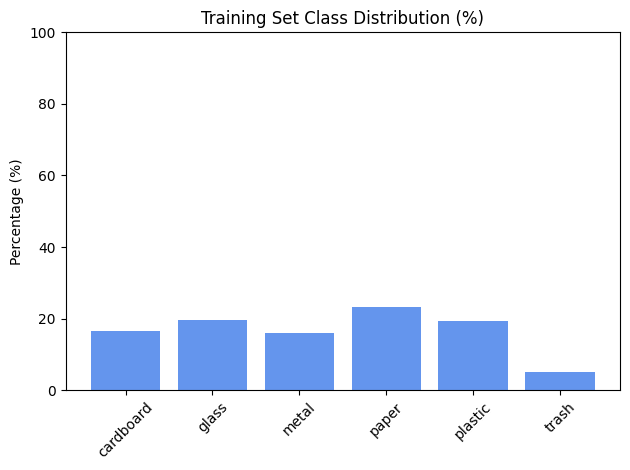

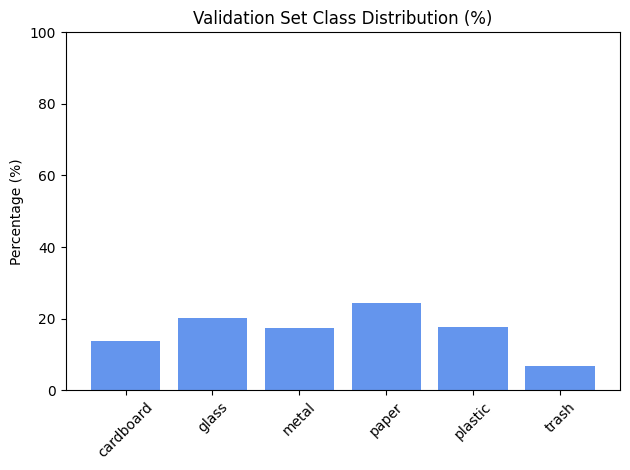

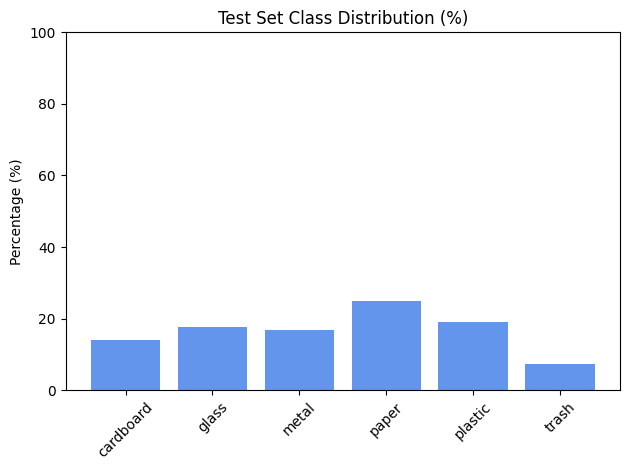

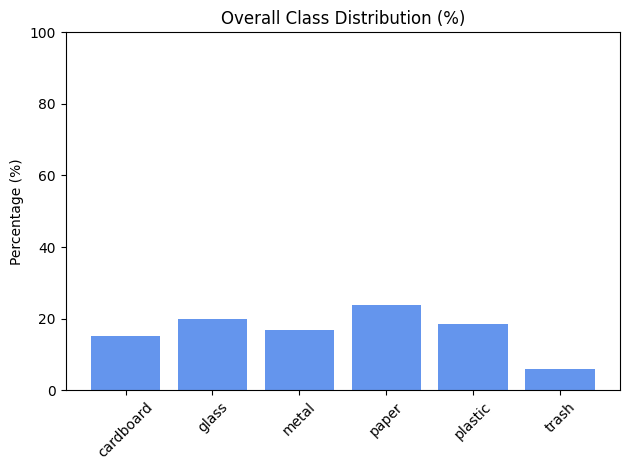

In [29]:
# Visualizing the distribution

def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# visualize the distrbution
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


###  Data Augmentation & Rescaling

##### We don’t have a lot of images, so the model might end up just memorizing them instead of learning to generalize — this is called overfitting. Also, since neural networks work better with smaller, consistent input values, we scale the pixel values in our images from 0–255 down to 0–1 to help the model learn more effectively.

In [ ]:
# counting class occurrences and preparing label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [31]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [ ]:
#data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

#### Using EfficientNetV2B2

In [ ]:
# load the pretrained EfficientNetV2B2 model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  freeze early layers to retain general pretrained features
base_model.trainable = True
for layer in base_model.layers[:100]:  
    layer.trainable = False


In [36]:
# building the final model(top layer)
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3), # hepls in preventing overfitting
    layers.Dense(6, activation='softmax')  #6 is hte number of classes
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            
    patience=3,                   
    restore_best_weights=True     
)

# set the number of epochs to train the model(number of times the model will go through the entire model)
epochs = 15  

# training the model 
history = model.fit(
    train_ds,                
    validation_data=val_ds,   
    epochs=epochs,           
    class_weight=class_weights,  #for handling class imbalance
    batch_size=32,           
    callbacks=[early]        
)


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 758ms/step - accuracy: 0.2783 - loss: 1.7428 - val_accuracy: 0.5762 - val_loss: 1.2671
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 719ms/step - accuracy: 0.6432 - loss: 1.0951 - val_accuracy: 0.7307 - val_loss: 0.8740
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 695ms/step - accuracy: 0.7700 - loss: 0.7384 - val_accuracy: 0.8059 - val_loss: 0.6244
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 743ms/step - accuracy: 0.8404 - loss: 0.5325 - val_accuracy: 0.8277 - val_loss: 0.5034
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 736ms/step - accuracy: 0.8829 - loss: 0.3912 - val_accuracy: 0.8436 - val_loss: 0.4454
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8937 - loss: 0.3061 - val_accuracy: 0.8554 - val_loss: 0.3993
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9350 - loss: 0.2131 - val_accuracy: 0.8653 - val_loss: 0.3734
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9413 - loss: 0.1929 - val_accuracy: 0.8

In [37]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [39]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 124, 124,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 124, 124,  │          0 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

### Visualizing the learning curves

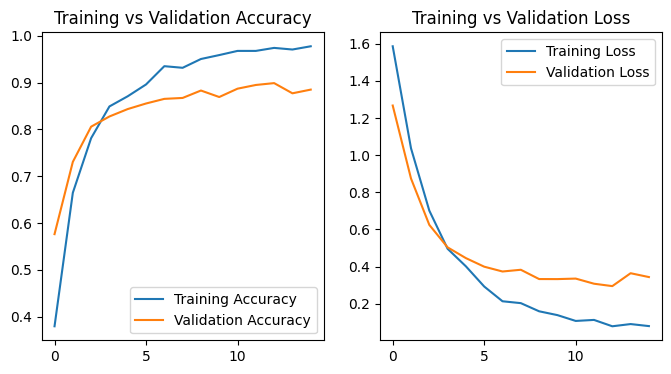

In [38]:
acc = history.history['accuracy']          
val_acc = history.history['val_accuracy']  
loss = history.history['loss']             
val_loss = history.history['val_loss']     

epochs_range = range(len(acc))             

plt.figure(figsize=(8,4))                 

plt.subplot(1,2,1)                         
plt.plot(epochs_range, acc, label='Training Accuracy')       
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')              
plt.title('Training vs Validation Accuracy') 

plt.subplot(1,2,2)                       
plt.plot(epochs_range, loss, label='Training Loss')         
plt.plot(epochs_range, val_loss, label='Validation Loss')   
plt.legend(loc='upper right')              
plt.title('Training vs Validation Loss')   

plt.show()   


## Model Evaluation

In [40]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.8971 - loss: 0.2803
Test accuracy is0.8984, Test loss is 0.3064


In [41]:
# extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # converting Tensor labels(images, label) to NumPy array and concatenate them

# getting predictions 
y_pred = model.predict(test_ds_eval) 
y_pred = np.argmax(y_pred, axis=1)  # select the class with the highest probability for each sample i.e. it takes the index of the highest value in each row

cm = confusion_matrix(y_true, y_pred)  

print(cm)  
print(classification_report(y_true, y_pred))  

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
[[27  0  3  2  0  0]
 [ 0 50  9  0  1  0]
 [ 0  0 40  0  0  0]
 [ 3  0  1 56  1  0]
 [ 0  0  1  0 43  3]
 [ 0  0  2  0  0 14]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        32
           1       1.00      0.83      0.91        60
           2       0.71      1.00      0.83        40
           3       0.97      0.92      0.94        61
           4       0.96      0.91      0.93        47
           5       0.82      0.88      0.85        16

    accuracy                           0.90       256
   macro avg       0.89      0.90      0.89       256
weighted avg       0.92      0.90      0.90       256



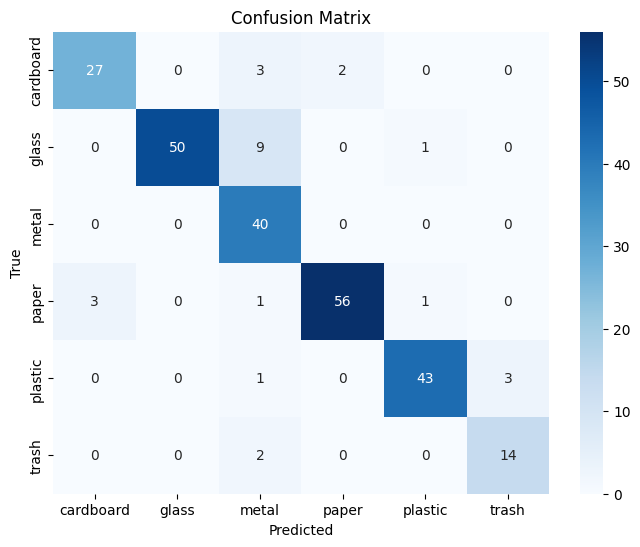

In [44]:
# plotting the confusion matrix
plt.figure(figsize=(8,6))  

sns.heatmap(cm, annot=True, fmt='d',  
            xticklabels=class_names,  
            yticklabels=class_names,  
            cmap='Blues')  

plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.title('Confusion Matrix')  
plt.show() 

## Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


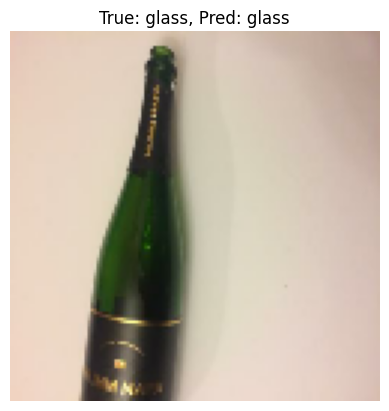

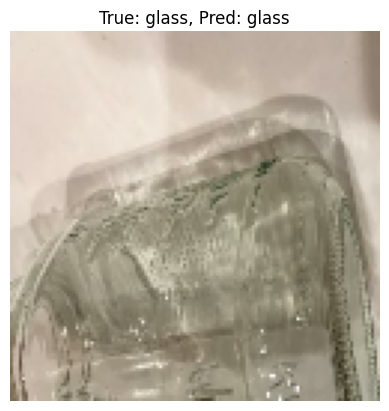

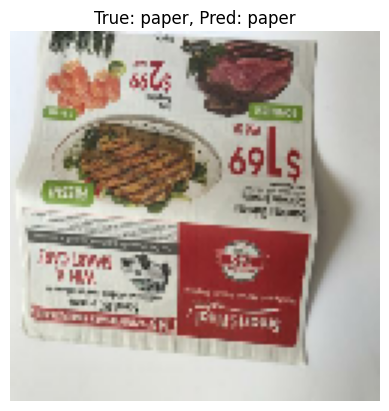

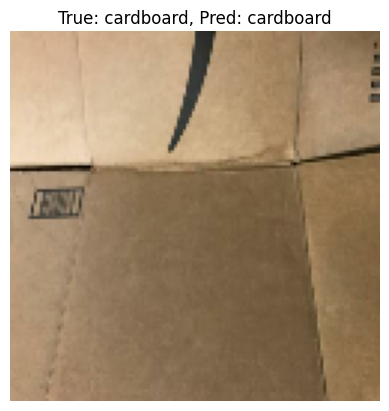

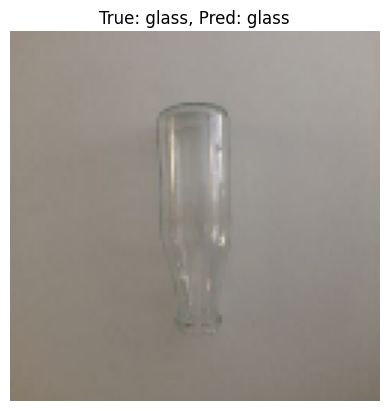

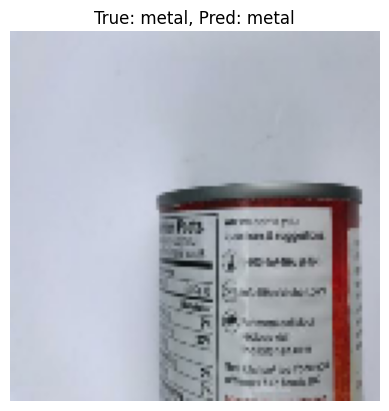

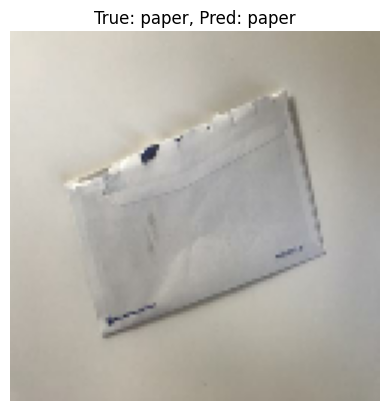

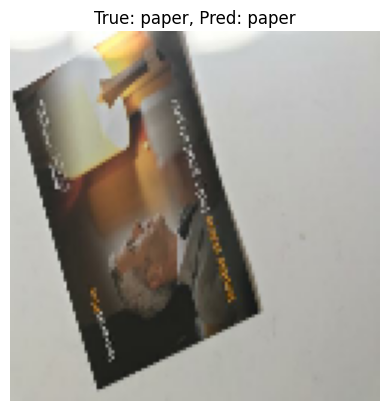

In [45]:
class_names = train_ds.class_names  

# take one batch of test images and labels
for images, labels in test_ds_eval.take(1):  
    predictions = model.predict(images)  
    pred_labels = tf.argmax(predictions, axis=1)  

    # looping through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}") 
        plt.axis("off")  
        plt.show()

### Using ResNet50

In [47]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(124, 124, 3)
)
base_model.trainable = False  # freeze the base model

data_augmentation ,

model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  
])


model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 407ms/step - accuracy: 0.1810 - loss: 2.5285 - val_accuracy: 0.3010 - val_loss: 1.7624
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 418ms/step - accuracy: 0.3222 - loss: 1.9785 - val_accuracy: 0.4614 - val_loss: 1.4561
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 436ms/step - accuracy: 0.4022 - loss: 1.6746 - val_accuracy: 0.5307 - val_loss: 1.2778
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 445ms/step - accuracy: 0.4580 - loss: 1.5513 - val_accuracy: 0.5683 - val_loss: 1.1603
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 441ms/step - accuracy: 0.5164 - loss: 1.3590 - val_accuracy: 0.5861 - val_loss: 1.0877
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 449ms/step - accuracy: 0.5606 - loss: 1.2352 - val_accuracy: 0.6119 - val_loss: 1.0278
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.5770 - loss: 1.1735 - val_accuracy: 0.6317 - val_loss: 0.9875
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 428ms/step - accuracy: 0.6096 - loss: 1.0909 - val_accu

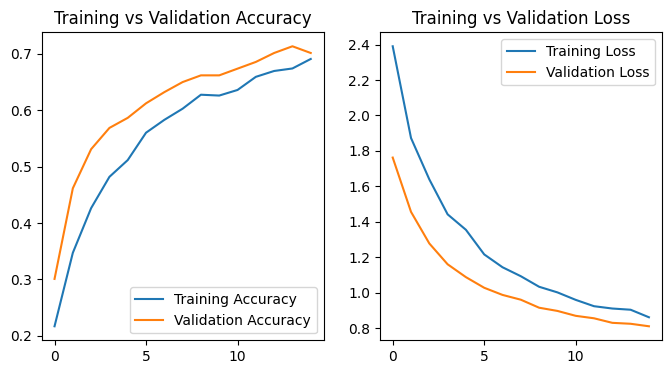

In [48]:
acc = history.history['accuracy']          
val_acc = history.history['val_accuracy']  
loss = history.history['loss']             
val_loss = history.history['val_loss']     

epochs_range = range(len(acc))             

plt.figure(figsize=(8,4))                 

plt.subplot(1,2,1)                         
plt.plot(epochs_range, acc, label='Training Accuracy')       
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')              
plt.title('Training vs Validation Accuracy') 

plt.subplot(1,2,2)                       
plt.plot(epochs_range, loss, label='Training Loss')         
plt.plot(epochs_range, val_loss, label='Validation Loss')   
plt.legend(loc='upper right')              
plt.title('Training vs Validation Loss')   

plt.show()   

In [49]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  

 
y_pred = model.predict(test_ds_eval) 
y_pred = np.argmax(y_pred, axis=1)  

cm = confusion_matrix(y_true, y_pred)  

print(cm)  
print(classification_report(y_true, y_pred))  

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step
[[20  0  0 10  0  2]
 [ 2 35  9  1  9  4]
 [ 0  2 33  1  1  3]
 [ 7  1  0 45  2  6]
 [ 1  6  6  2 27  5]
 [ 1  1  3  1  0 10]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        32
           1       0.78      0.58      0.67        60
           2       0.65      0.82      0.73        40
           3       0.75      0.74      0.74        61
           4       0.69      0.57      0.63        47
           5       0.33      0.62      0.43        16

    accuracy                           0.66       256
   macro avg       0.64      0.66      0.64       256
weighted avg       0.69      0.66      0.67       256



### Clearly EfficientNetV2B2 is the winner

### Saving the best model

In [50]:
model.save('best_model(EfficientNet).keras')